Sampling by  Uniform
before adding points from charectaristics, N_pde= 20000
after adding points from charectaristics, N_pde =  20000
--- Start Pre-training (Fitting BC/IC only) ---
Pretrain Epoch 0: Loss Data: 0.20310
Pretrain Epoch 200: Loss Data: 0.00229
Pretrain Epoch 400: Loss Data: 0.00016
Pretrain Epoch 600: Loss Data: 0.00006
Pretrain Epoch 800: Loss Data: 0.00004
--- Pre-training done (4.9 sec). Starting Physics training ---
Physics Epoch 0: Total: 0.79870, Data: 0.00004, PDE: 0.79866
Physics Epoch 200: Total: 0.10203, Data: 0.06727, PDE: 0.03477
Physics Epoch 400: Total: 0.09480, Data: 0.06425, PDE: 0.03055
Physics Epoch 600: Total: 0.09060, Data: 0.06255, PDE: 0.02805
Physics Epoch 800: Total: 0.08593, Data: 0.05946, PDE: 0.02647
Physics Epoch 1000: Total: 0.08181, Data: 0.05625, PDE: 0.02556
Physics Epoch 1200: Total: 0.07981, Data: 0.05438, PDE: 0.02543
Physics Epoch 1400: Total: 0.07870, Data: 0.05340, PDE: 0.02530
Physics Epoch 1600: Total: 0.07764, Data: 0.05266, PDE: 0

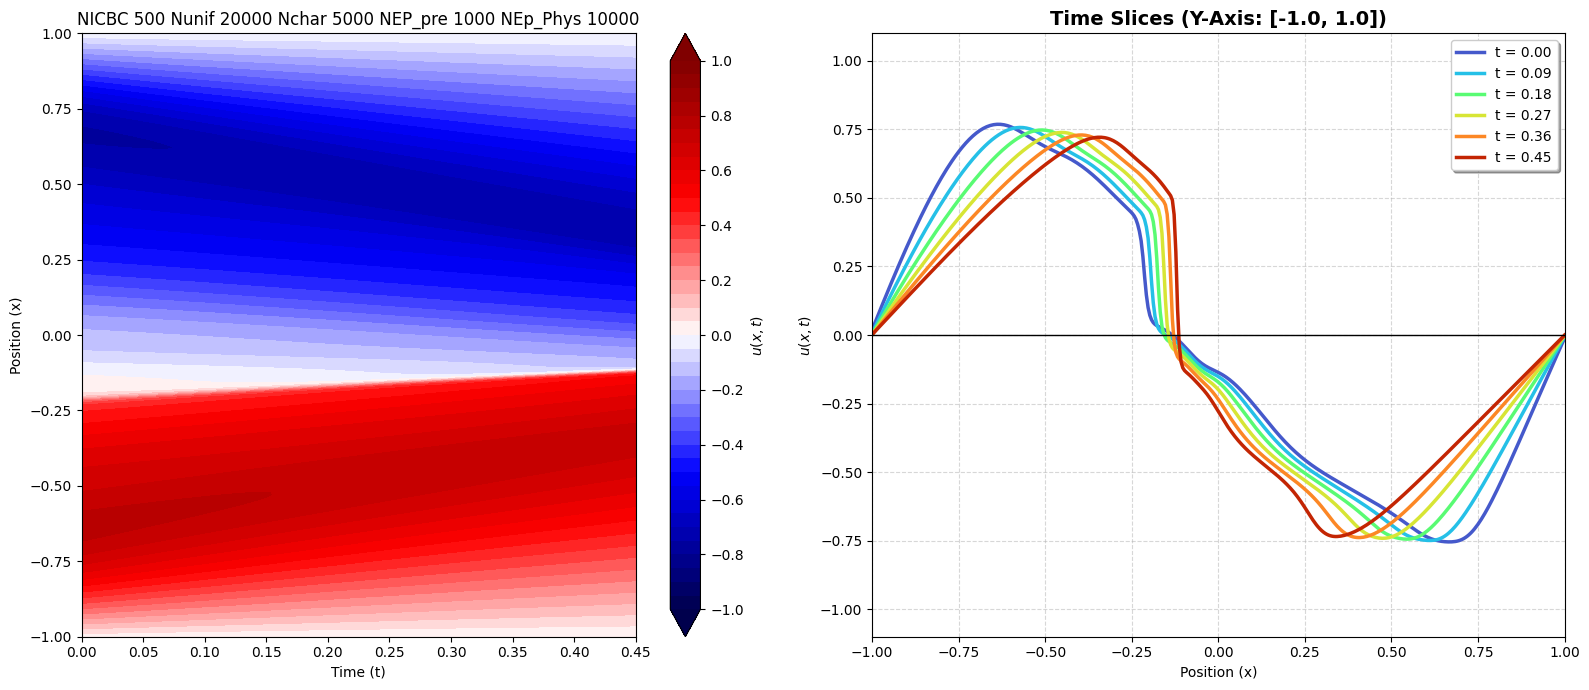

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import timeit
tf.random.set_seed(42)
np.random.seed(42)
DTYPE = tf.float32
VISCOSITY = 0.001  

def get_data(N_data, N_pde,sampling_method='Uniform'):
    """
    N_data: מספר נקודות על השפה והתחלה (BC + IC)
    N_pde: מספר נקודות קולוקציה בתוך התחום (Collocation Points)
    """
    
    # --- תנאי התחלה (Initial Condition): t=0, x in [-1, 1] ---
    # נשתמש ב- -sin(pi*x) שהוא הסטנדרט למשוואת בורגרס
    x_ic = np.random.uniform(-1, 1, N_data // 2).reshape(-1, 1)
    t_ic = np.zeros_like(x_ic)
    u_ic = -np.sin(np.pi * x_ic) 
    X_ic = np.hstack([x_ic, t_ic])
    
    # --- תנאי שפה (Boundary Conditions): x=-1 or x=1, t in [0, 1] ---
    t_bc = np.random.uniform(0, 1, N_data // 2).reshape(-1, 1)
    x_bc = np.random.choice([-1.0, 1.0], N_data // 2).reshape(-1, 1)
    u_bc = np.zeros_like(t_bc) # u=0 בקצוות
    X_bc = np.hstack([x_bc, t_bc])
    
    # איחוד דאטה לאימון (IC + BC)
    X_data = np.vstack([X_ic, X_bc])
    u_data = np.vstack([u_ic, u_bc])
    
 # --- נקודות קולוקציה (PDE Points): בתוך התחום ---
    x_pde = np.random.uniform(-1, 1, N_pde).reshape(-1, 1)
    t_pde = np.random.uniform(0, 1, N_pde).reshape(-1, 1)
    X_pde = np.hstack([x_pde, t_pde])
    print ('Sampling by ',sampling_method)
    print ('before adding points from charectaristics, N_pde=',N_pde)
    #print ('# of collocation points (random): ',np.shape(X_pde))
    if sampling_method == 'Charectarisitcs':
        X_pde_in = np.loadtxt('X_pde_Charecataristics.csv', delimiter=',')
        X_pde = np.concatenate((X_pde,X_pde_in))
        N_pde = N_pde + np.shape(X_pde_in)[0]
        #print ('# of collocation points (Charectarisitcs): ',np.shape(X_pde_in))   
    #print ('# of collocation points (total):',np.shape(X_pde))
    print ('after adding points from charectaristics, N_pde = ',N_pde)

    # המרה לטנזורים של TF
    X_data = tf.convert_to_tensor(X_data, dtype=DTYPE)
    u_data = tf.convert_to_tensor(u_data, dtype=DTYPE)
    X_pde = tf.convert_to_tensor(X_pde, dtype=DTYPE)
    return X_data, u_data, X_pde

def init_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))    
    for _ in range(4):
        model.add(tf.keras.layers.Dense(20, activation='tanh', 
                                        kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(1, activation=None)) # יציאה לינארית
    return model

@tf.function
def train_step(model, optimizer, x_data, y_data, x_pde, apply_pde_loss):
    with tf.GradientTape() as tape:
        # --- חלק 1: Loss על הדאטה (תמיד פעיל) ---
        u_pred_data = model(x_data)
        loss_data = tf.reduce_mean(tf.square(y_data - u_pred_data))        
        loss_pde = tf.constant(0.0, dtype=DTYPE)
        # --- חלק 2: Loss פיזיקלי (פעיל רק בשלב השני) ---
        if apply_pde_loss:
            # חישוב נגזרות אוטומטי
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_pde)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(x_pde)
                    u = model(x_pde)
                # נגזרות ראשונות (x, t)
                grads = tape1.gradient(u, x_pde)
                u_x = grads[:, 0:1]
                u_t = grads[:, 1:2]
           # נגזרת שניה (xx)
            grad_u_x = tape2.gradient(u_x, x_pde)
            u_xx = grad_u_x[:, 0:1]
            del tape1, tape2 
            # משוואת בורגרס: u_t + u*u_x - v*u_xx = 0
            f = u_t + (u * u_x) - (VISCOSITY * u_xx)
            loss_pde = tf.reduce_mean(tf.square(f))
        
        total_loss = loss_data + loss_pde
    # עדכון משקולות
    grads_weights = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads_weights, model.trainable_variables))   
    return total_loss, loss_data, loss_pde

def plot_solution(model,file_name,title):
    x_min, x_max = -1.0, 1.0
    v_min, v_max = -1.0, 1.0
    levels = np.linspace(v_min, v_max, 41)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    #x =  np.loadtxt('exact_sol_x_grid.csv', delimiter=',')
    #t =  np.loadtxt('exact_sol_t_grid.csv', delimiter=',')
    x = np.linspace(-1, 1, 400)
    t = np.linspace(0, 0.45, 200)
    X, T = np.meshgrid(x, t)    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    X_star = tf.cast(X_star, dtype=DTYPE)
    u_pred = model(X_star)
    U = u_pred.numpy().reshape(X.shape)
    cf = ax1.contourf(T, X, U, levels=levels, cmap='seismic', extend='both')
    cf = ax1.contourf(T, X, U, levels=levels, cmap='seismic', extend='both')
    #ax1.set_title(f"PINN (N_DATA,N_PDE,NE_PRE, NE_PDE: [{sampling_method}, {N_DATA}, {N_PDE},{EPOCHS_PRETRAIN}, {EPOCHS_PHYSICS}])", fontsize=14, fontweight='bold')
    ax1.set_title(title)
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Position (x)')
    fig.colorbar(cf, ax=ax1, label='$u(x,t)$', ticks=np.linspace(v_min, v_max, 11))
    actual_nt = U.shape[0]    
    steps_to_plot = np.linspace(0, actual_nt-1, 6, dtype=int)
    colors = plt.cm.turbo(np.linspace(0.1, 0.9, len(steps_to_plot)))
    for i, step in enumerate(steps_to_plot):
        # U[step, :] שולף את כל ערכי ה-x עבור זמן ספציפי t[step]
        ax2.plot(x, U[step,:], label=f't = {t[step]:.2f}', color=colors[i], lw=2.5)
    ax2.set_title(f"Time Slices (Y-Axis: [{v_min}, {v_max}])", fontsize=14, fontweight='bold')
    ax2.set_xlabel('Position (x)')
    ax2.set_ylabel('$u(x,t)$')
    ax2.set_ylim(v_min - 0.1, v_max + 0.1) # תוספת קטנה למרווח נשימה ויזואלי
    ax2.set_xlim(x_min, x_max)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(loc='upper right', frameon=True, shadow=True)
    ax2.axhline(0, color='black', lw=1) # קו אפס מרכזי
    plt.tight_layout()
    plt.show()
    space = '_'
    #file_name = 'Sampling_'+sampling_method+'_seed_'+str(iseed)+'_NDATA_'+str(N_DATA)+'_NPDE_'+str(N_PDE)+'_EPOCHS_PRETRAIN_'+str(EPOCHS_PRETRAIN)+'_EPOCHS_PHYSICS_'+str(EPOCHS_PHYSICS)+'.png'
    fig.savefig(file_name)
    
def check_causality_violations(model, nu, x_range=(-1, 1), t_range=(0, 1), n_points=100):
    # 1. יצירת רשת נקודות לבדיקה
    x_vals = np.linspace(x_range[0], x_range[1], n_points)
    t_vals = np.linspace(t_range[0], t_range[1], n_points)
    X, T = np.meshgrid(x_vals, t_vals)
    x_flat = tf.convert_to_tensor(X.flatten()[:, None], dtype=tf.float32)
    t_flat = tf.convert_to_tensor(T.flatten()[:, None], dtype=tf.float32)
    # 2. חישוב ה-Residual הפיזיקלי
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_flat)
        tape.watch(t_flat)
        u = model(tf.concat([x_flat, t_flat], axis=1))
        u_x = tape.gradient(u, x_flat)
        u_t = tape.gradient(u, t_flat)
    u_xx = tape.gradient(u_x, x_flat)
    # f = u_t + u*u_x - nu*u_xx
    residual = u_t + u * u_x - nu * u_xx
    res_sq = tf.square(residual).numpy().reshape(n_points, n_points)
    # 3. חישוב מדד הקוזאליות (Loss לכל רגע זמן)
    temporal_loss = np.mean(res_sq, axis=1) # ממוצע על פני X לכל T
    # 4. ויזואליזציה
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # גרף 1: מפת חום של השאריות (Residual Map)
    im = ax[0].pcolormesh(T, X, res_sq, cmap='inferno', shading='auto')
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title("PDE Residual Map $(f^2)$")
    ax[0].set_xlabel("Time (t)")
    ax[0].set_ylabel("Space (x)")
    # גרף 2: שגיאה כפונקציה של הזמן
    ax[1].plot(t_vals, temporal_loss, lw=2)
    ax[1].set_yscale('log')
    ax[1].set_title("Mean Residual vs Time")
    ax[1].set_xlabel("Time (t)")
    ax[1].set_ylabel("Mean Squared Residual")
    ax[1].grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()
 
    early_loss = np.mean(temporal_loss[:n_points//10])
    late_loss = np.mean(temporal_loss[-n_points//10:])
    causality_score = late_loss / early_loss
    print(f"--- Causality Diagnostics ---")
    print(f"Early Time Loss (t~0): {early_loss:.6f}")
    print(f"Late Time Loss (t~T):  {late_loss:.6f}")
    print(f"Causality Ratio:       {causality_score:.4f}")
    if causality_score < 0.1:
        print("⚠️ אזהרה: זוהתה הפרת קוזאליות חמורה! הרשת פותרת את העתיד טוב מהעבר.")
    else:
        print("✅ הקוזאליות נראית תקינה או שהאימון טרם התכנס.")




# === (Main) ===
#start = timeit.timeit()
iseed=12
random.seed(iseed)
N_DATA = 500
N_PDE = 20000    
EPOCHS_PRETRAIN = 1000  
EPOCHS_PHYSICS = 10000  
NPDE_string = '_NUnif_'+str(N_PDE)
sampling_method = 'Uniform'
#sampling_method = 'Charectarisitcs'
if sampling_method == 'Charectarisitcs':
    Nchar = np.shape(np.loadtxt('X_pde_Charecataristics.csv', delimiter=','))[0]
    NPDE_string = NPDE_string + '_Nchar_'+str(Nchar)+'_'
title = 'NICBC '+str(N_DATA)+' Nunif '+str(N_PDE)+' Nchar '+str(Nchar)+' NEP_pre '+str(EPOCHS_PRETRAIN)+' NEp_Phys '+str(EPOCHS_PHYSICS) 
#print (title) 
file_name = 'Sampling_'+sampling_method+'_seed_'+str(iseed)+'_NICBC_'+str(N_DATA)+NPDE_string+'NEP_pre_'+str(EPOCHS_PRETRAIN)+'_NEp_Phys_'+str(EPOCHS_PHYSICS)+'.png'
#print (file_name)


x_bc_train, u_bc_train, x_pde_train = get_data(N_DATA, N_PDE,sampling_method)
model = init_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

print("--- Start Pre-training (Fitting BC/IC only) ---")
start_time = time.time()
for epoch in range(EPOCHS_PRETRAIN):
    loss, l_data, l_pde = train_step(model, optimizer, x_bc_train, u_bc_train, x_pde_train, apply_pde_loss=False)
    if epoch % 200 == 0:
        print(f"Pretrain Epoch {epoch}: Loss Data: {l_data.numpy():.5f}")

print(f"--- Pre-training done ({time.time()-start_time:.1f} sec). Starting Physics training ---")

for epoch in range(EPOCHS_PHYSICS):
    loss, l_data, l_pde = train_step(model, optimizer, x_bc_train, u_bc_train, x_pde_train, apply_pde_loss=True)
    if epoch % 200 == 0:
        print(f"Physics Epoch {epoch}: Total: {loss.numpy():.5f}, Data: {l_data.numpy():.5f}, PDE: {l_pde.numpy():.5f}")
print("--- Training Finished ---")

#plot_solution(model,'N_DATA = '+str(N_DATA)+' N_PDE = '+str(N_PDE)+'Ep_pre = '+str(EPOCHS_PRETRAIN)+'Ep_P = '+str(EPOCHS_PHYSICS))    
#plot_solution(model,'N_DATA = '+str(N_DATA)+' N_PDE = '+str(N_PDE)+'Ep_pre = '+str(EPOCHS_PRETRAIN)+'Ep_P = '+str(EPOCHS_PHYSICS))    
plot_solution(model,file_name,title)
#check_causality_violations(model, nu=0.001/np.pi)
#end = timeit.timeit()
#print('time of run',end - start)